In [24]:
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import pandas as pd

In [25]:
dataset = pd.read_csv('../dataset/heart_2020_cleaned.csv')

dataset.replace( {'No': 0, 'Yes': 1, 'Female': 0, 'Male': 1, 'No, borderline diabetes': 0, 'Yes (during pregnancy)': 1}, inplace=True)
dataset.replace( {'0-17': 0, '18-24': 1, '25-29': 2, '30-34': 3, '35-39': 4, '40-44': 5, '45-49': 6, '50-54': 7, '55-59': 8, '60-64': 9, '65-69': 10, '70-74': 11, '75-79': 12, '80 or older': 13}, inplace=True)
dataset.drop(['Race', 'GenHealth','Stroke','DiffWalking','PhysicalHealth','Asthma','MentalHealth','Diabetic','KidneyDisease','SkinCancer'], axis=1,inplace=True)

feature_names = ['BMI','Smoking','AlcoholDrinking','Sex', 'AgeCategory','PhysicalActivity','SleepTime']
target_names = 'HeartDisease'

true_dataset  = []
false_dataset = []

df_positive = dataset[ dataset['HeartDisease'] == 1 ] 
df_negative = dataset[ dataset['HeartDisease'] == 0 ]
df_negative_cut = df_negative.sample(n = 30000)
dataset = pd.concat([df_positive, df_negative_cut])

target = dataset[target_names]
feature = dataset[feature_names]

print (target.value_counts())

0    30000
1    27373
Name: HeartDisease, dtype: int64


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    feature,target,
    test_size=0.2,
    random_state=np.random.randint(10))

In [27]:
model = Sequential()

model.add(Dense(7, input_shape=(7,), activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(3, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
early_break = EarlyStopping(monitor='loss', patience=5)
reduce_learning_rate = ReduceLROnPlateau(patience=3)

result = model.fit(X_train, y_train, epochs = 40, batch_size=10, validation_data=(X_test, y_test), callbacks=[early_break,reduce_learning_rate])

Epoch 1/40
4590/4590 [==============================] - 4s 811us/step - loss: 0.6017 - accuracy: 0.6841 - val_loss: 0.5812 - val_accuracy: 0.6986 - lr: 0.0010
Epoch 2/40
4590/4590 [==============================] - 4s 773us/step - loss: 0.5683 - accuracy: 0.7071 - val_loss: 0.5667 - val_accuracy: 0.7045 - lr: 0.0010
Epoch 3/40
4590/4590 [==============================] - 4s 776us/step - loss: 0.5613 - accuracy: 0.7114 - val_loss: 0.5633 - val_accuracy: 0.7082 - lr: 0.0010
Epoch 4/40
4590/4590 [==============================] - 4s 786us/step - loss: 0.5579 - accuracy: 0.7138 - val_loss: 0.5814 - val_accuracy: 0.6902 - lr: 0.0010
Epoch 5/40
4590/4590 [==============================] - 4s 804us/step - loss: 0.5565 - accuracy: 0.7147 - val_loss: 0.5587 - val_accuracy: 0.7138 - lr: 0.0010
Epoch 6/40
4590/4590 [==============================] - 4s 793us/step - loss: 0.5547 - accuracy: 0.7152 - val_loss: 0.5577 - val_accuracy: 0.7152 - lr: 0.0010
Epoch 7/40
4590/4590 [========================

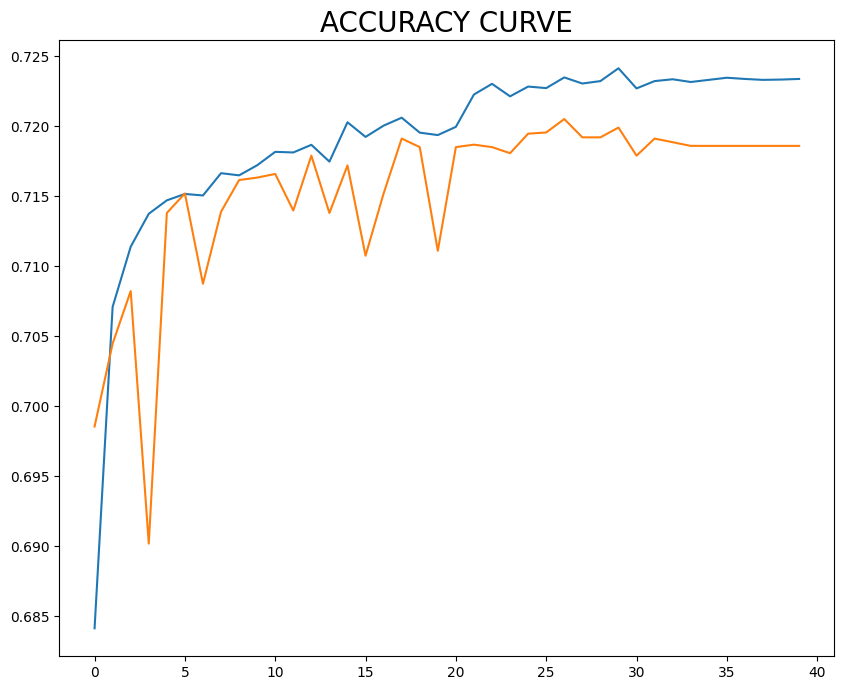

In [30]:
plt.figure(figsize=(10,8))
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

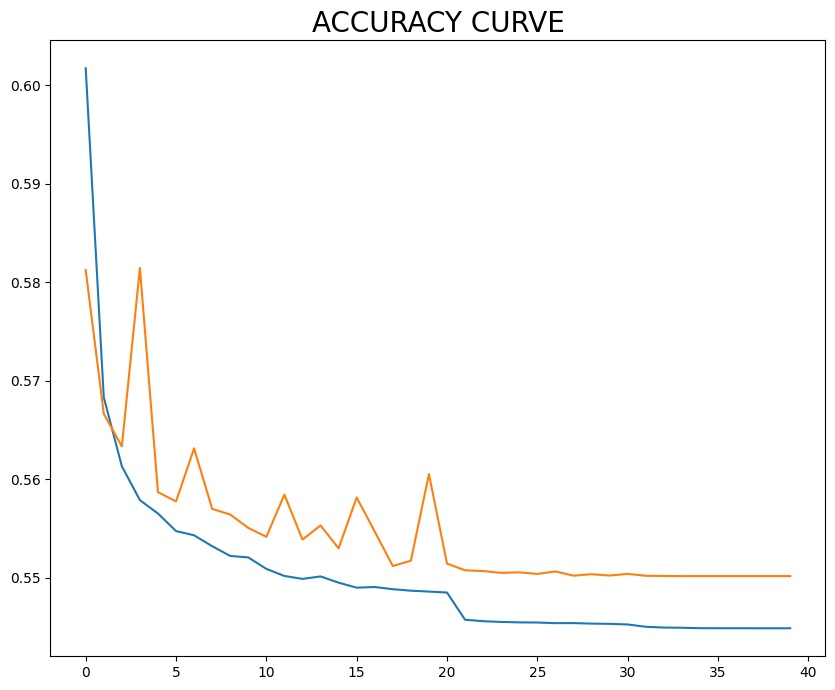

In [31]:
plt.figure(figsize=(10,8))
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

In [32]:
model.evaluate(X_test, y_test)

359/359 [==============================] - 0s 556us/step - loss: 0.5502 - accuracy: 0.7186


[0.5501705408096313, 0.718605637550354]

In [33]:
model.save('./model',overwrite=True)

INFO:tensorflow:Assets written to: ./model\assets
